<h1 align="center"> Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods</h1>
<h2 align="center"> Is a real estate sell price good, fair, or above average?</h2>

### Background and Proposal

When you want to by a car, you go to [AutoTrader](https://www.autotrader.ca/) or [CarGuru](https://ca.cargurus.com/). One sweet thing about using such websites is that they tell you the car you are interested has a below-market price or above market price based on their own algorithms. 

However, when you looking for either renting or buying a real estate from websites such as [Centris](https://www.centris.ca/en/) or [DuProprio](https://duproprio.com/en), you won't be able to find neither if similar real estate exists somewhere else in the city nor if it's price is below market (a.k.a., a good deal).

Is such thing should be done? I certainly think so. One of my friends recently wants to buy a condomunium in Montreal. He told me it is exhausting to find an ideal condo to buy. Sometime the location is acceptable but the price is way above the budget, sometimes the price is fair but location isn't ideal. He literrally has to view all the available condos and compare them by heart to determine which one is the best.

My friend's experience has intrggered me to develop a tool that can:

1. find similar for－sale real estate by using classification and city segmentation;
2. analyze price within certain cluster to see if the sale price is above or below the market.

This tool can help to fast locate other similar real estates once you have on in mind. It also sets a reference on price to help you determine which one is worth buying.

How am I going to do it? The first and foremost step is to find the for sale real estates. I intend to use web crawler to get data from [DuProprio](https://duproprio.com/en). The real estate data shall have the following information:

- address
- sale price
- number of rooms
- areas
- built year

Then I will use the address to extract the neighbourhood informaiton from [Foursquare](https://foursquare.com/city-guide). I will categorize the neighbourhood venues into several main categories such as:

- parks
- grocery stores
- schools
- clinic/hospital
- public transportation

All the data shall be ready by now. The tool will take one specific real estate as an input and find all similar ones by using segmentation and clustering technique. Then we further analyze the price within that cluster. Finally, display all the candidates in ascending order of (actual price - predicted price).

### Data

I used a [web scrawler](https://github.com/Alcander-Z/MTL_house) to collect data about real estate for sale from [DuProprio](https://duproprio.com/en/search/list?search=true&regions%5B0%5D=6&is_for_sale=1&with_builders=1&parent=1&pageNumber=1&sort=-published_at). The raw data is saved as JSON file. It is available at [Here](https://github.com/Alcander-Z/Coursera_Capstone/blob/master/duproprio-20190517.json)

Let's load it and convert to pandas DataFrame.

In [1]:
import json
import pandas as pd

In [2]:
with open(r'duproprio-20190517.json', 'r') as f:
    jsf = json.load(f)
df = pd.DataFrame.from_dict(jsf)

Let's see the number of rows and columns of the dataframe

In [3]:
df.shape

(1099, 13)

Let's the column names

In [4]:
df.columns.values

array(['address', 'areas', 'backyard', 'bathrooms', 'bedrooms',
       'category', 'floor_if_condo', 'levels', 'municipal', 'ownership',
       'postalcode', 'price', 'year'], dtype=object)

There are 13 attributes (columns) of a real estate:

- address and postalcode shall be used to define neighbourhood;
- areas, bathrooms, bedrooms, years shall be used for the price regression model;

Let's further look into the 'category' column:

In [5]:
df.category.value_counts()

Condominium      517
New              110
2                 80
Duplex            72
Bungalow          72
Townhouse         63
Triplex           54
Semi-detached     39
Split             22
Quadruplex        19
Quintuplex        14
Commercial         8
Loft               6
6                  6
Penthouse          4
Storey             4
Residential        4
Raised             2
3                  2
Bi-generation      1
Name: category, dtype: int64

Category defines the type of a real estate. It is obvious that 'Condominium' is dominant in numbers among all. I will only use __condominium__ to continue the analysis.

In [6]:
subsets = ['price', 'address', 'category', 'year', 'bedrooms', 'bathrooms', 'areas', 'postalcode']
df.dropna(subset=subsets, axis=0, inplace=True)
df.drop(columns=['ownership', 'levels'], inplace=True)
condo = df[df.category=='Condominium'].reset_index(drop=True)
condo.head()

,address,areas,backyard,bathrooms,bedrooms,category,floor_if_condo,municipal,postalcode,price,year
0,"5985 Boyer, Rosemont / La Petite Patrie, QC","2,000 ft² (185.81 m²)",East,2.5,3.0,Condominium,1.0,394000.0,H2S 2H8,599000,1928
1,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC","1,100 ft² (102.19 m²)",None,1.5,2.0,Condominium,10.0,316600.0,H1H 0A1,349000,2006
2,"16107 rue Forsyth, Pointe-Aux-Trembles / Montr...",911 ft² (84.63 m²),North-West,1.0,2.0,Condominium,3.0,207200.0,H1A 5R8,200000,1999
3,"711-680 rue de Courcelles, Le Sud-Ouest, QC",950 ft² (88.26 m²),South,1.0,2.0,Condominium,7.0,339500.0,H4C 0B8,415000,2011
4,"1-5230 rue Resther, Le Plateau-Mont-Royal, QC",106.4 m² (1 145.28 ft²),None,2.5,2.0,Condominium,1.0,350700.0,H2J 2W3,415000,2005


In [7]:
print("invalid backyard numbers: ", condo.backyard.isna().sum())
print("invalid municipal numbers: ", condo.municipal.isna().sum())

invalid backyard numbers:  231
invalid municipal numbers:  241


There are a few things shall be done before city segmentation and price regression modeling:

1. extract proper number of 'areas' from the string, (e.g., use $m^2$ as area unit);
2. add neighbourhood information for each condo;
3. use Foursquare to get venue information for each neighbourhood;
4. drop category;
5. drop backyard/municipal since nearly half of them are None.

In [8]:
condo.to_csv('condo_montreal.csv')

To download the dataset, [click here](https://github.com/Alcander-Z/Coursera_Capstone/blob/master/MTL_Condominium.csv)

### Methodology

#### extract area in $m^2$

In [9]:
import re
def get_area(string):
    """
    string format is either:
        xxxx ft^2 (xxxx m^2)
    or:
        xxx m^2 (xxxx ft^2)
    """
    unit = u'm\u00B2'
    pattern = '\d*\.?\d+' + ' ' + unit
    match = re.findall(pattern, string)
    try:
        return match[0].split()[0]
    except:
        return None

In [10]:
area = list(map(get_area, condo.areas))
condo.areas = area
condo.dropna(axis=0, subset=['areas'], inplace=True)
condo.areas.astype('float')
condo.head()

,address,areas,backyard,bathrooms,bedrooms,category,floor_if_condo,municipal,postalcode,price,year
0,"5985 Boyer, Rosemont / La Petite Patrie, QC",185.81,East,2.5,3.0,Condominium,1.0,394000.0,H2S 2H8,599000,1928
1,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC",102.19,None,1.5,2.0,Condominium,10.0,316600.0,H1H 0A1,349000,2006
2,"16107 rue Forsyth, Pointe-Aux-Trembles / Montr...",84.63,North-West,1.0,2.0,Condominium,3.0,207200.0,H1A 5R8,200000,1999
3,"711-680 rue de Courcelles, Le Sud-Ouest, QC",88.26,South,1.0,2.0,Condominium,7.0,339500.0,H4C 0B8,415000,2011
4,"1-5230 rue Resther, Le Plateau-Mont-Royal, QC",106.4,None,2.5,2.0,Condominium,1.0,350700.0,H2J 2W3,415000,2005


#### drop category, backyard, municipal, floor_if_condo

In [11]:
condo.drop(columns=['backyard', 'category', 'floor_if_condo', 'municipal'], inplace=True)

#### neighbourhood is defined by the first 3 postalcode

postal code - borough map is crawled from [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H). It is stored in a json file, with key of first 3 postalcode and value of neighbourhood name (e.g., "H1A": "Pointe-aux-Trembles")

In [12]:
with open(r'mtl_postalcode.json', 'r') as f:
    borough = json.load(f)

In [13]:
def get_borough(postal):
    postal = postal.strip()
    key = postal[:3]
    return borough.get(key, None)

In [16]:
condo['borough'] = list(map(get_borough, condo.postalcode))

In [17]:
condo.dropna(axis=0, subset=['borough'], inplace=True)
condo.reset_index(drop=True, inplace=True)
condo.head()

,address,areas,bathrooms,bedrooms,postalcode,price,year,borough
0,"5985 Boyer, Rosemont / La Petite Patrie, QC",185.81,2.5,3.0,H2S 2H8,599000,1928,Petite-Patrie
1,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC",102.19,1.5,2.0,H1H 0A1,349000,2006,Montréal-Nord
2,"16107 rue Forsyth, Pointe-Aux-Trembles / Montr...",84.63,1.0,2.0,H1A 5R8,200000,1999,Pointe-aux-Trembles
3,"711-680 rue de Courcelles, Le Sud-Ouest, QC",88.26,1.0,2.0,H4C 0B8,415000,2011,Saint-Henri
4,"1-5230 rue Resther, Le Plateau-Mont-Royal, QC",106.4,2.5,2.0,H2J 2W3,415000,2005,Plateau Mont-Royal


Let's simply review some aggregated info by borough

In [31]:
condo.head()

,address,areas,bathrooms,bedrooms,postalcode,price,year,borough
0,"5985 Boyer, Rosemont / La Petite Patrie, QC",185.81,2.5,3.0,H2S 2H8,599000,1928,Petite-Patrie
1,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC",102.19,1.5,2.0,H1H 0A1,349000,2006,Montréal-Nord
2,"16107 rue Forsyth, Pointe-Aux-Trembles / Montr...",84.63,1.0,2.0,H1A 5R8,200000,1999,Pointe-aux-Trembles
3,"711-680 rue de Courcelles, Le Sud-Ouest, QC",88.26,1.0,2.0,H4C 0B8,415000,2011,Saint-Henri
4,"1-5230 rue Resther, Le Plateau-Mont-Royal, QC",106.4,2.5,2.0,H2J 2W3,415000,2005,Plateau Mont-Royal


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

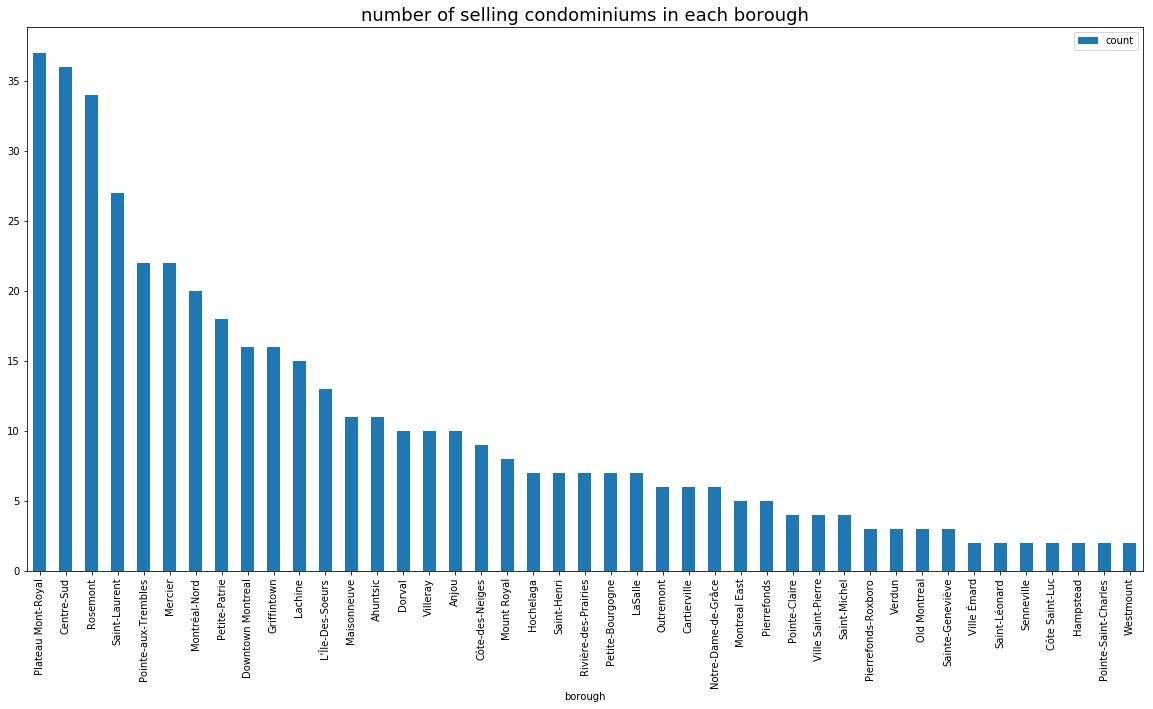

In [42]:
condo_borough_count = condo[['address', 'borough']].groupby('borough').count().sort_values(by='address', ascending=False).rename({'address':'count'},axis='columns')
fig, ax = plt.subplots(1,1, figsize=(20,10))
condo_borough_count.plot.bar(ax=ax)
ax.set_title('number of selling condominiums in each borough', fontsize=18)
plt.show()

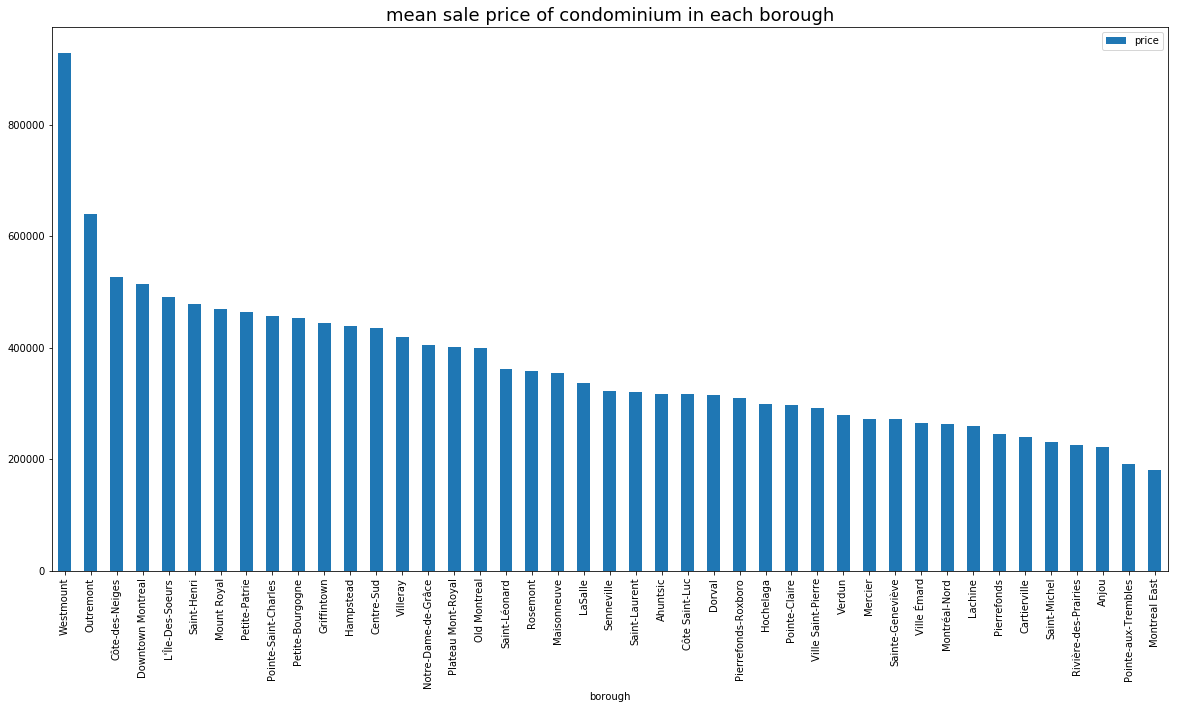

In [47]:
condo.price = condo.price.astype('float')
condo_borough_price = condo[['price', 'borough']].groupby('borough').mean().sort_values(by='price', ascending=False)
fig, ax = plt.subplots(1,1, figsize=(20,10))
condo_borough_price.plot.bar(ax=ax)
ax.set_title('mean sale price of condominium in each borough', fontsize=18)
plt.show()

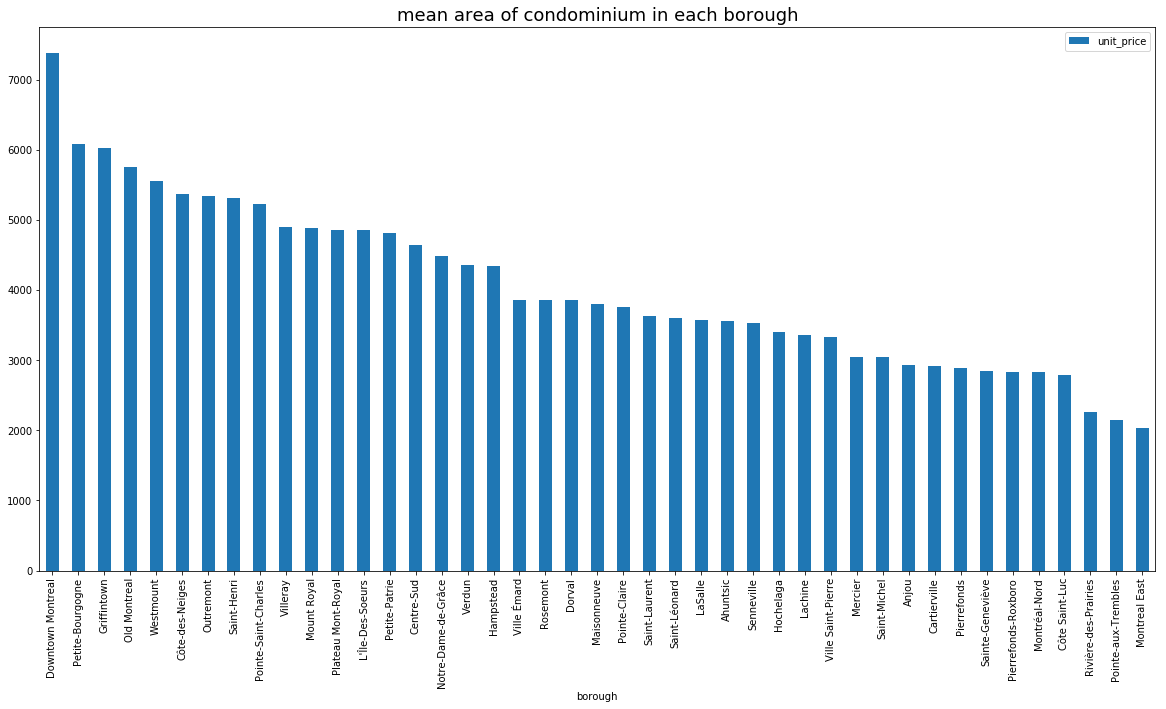

In [53]:
condo.areas = condo.areas.astype('float')
condo_borough_area = condo[['areas', 'borough']].groupby('borough').mean().sort_values(by='areas', ascending=False)
condo_borough_price_area = condo_borough_area.merge(condo_borough_price, how='inner', left_index=True, right_index=True)
condo_borough_price_area['unit_price'] = condo_borough_price_area['price'] / condo_borough_price_area['areas']
condo_borough_price_area.sort_values(by='unit_price', ascending=False, inplace=True)
fig, ax = plt.subplots(1,1, figsize=(20,10))
condo_borough_price_area.plot.bar(y='unit_price', ax=ax)
ax.set_title('mean price per square meter of condominium in each borough', fontsize=18)
plt.show()

Montreal has 123 neighbourhoods in total and 43 of them have condos for sale; __Plateau Mont-Royal__, __Centre-Sud__, and __Rosemont__ are top three neighbourhoods in the number of condos for sale; though __Westmount__ has only two selling condos, their average sale price is much higher than the price of condos in other neighbourhoods; __Downtown Montreal__ has the most expensive condo for sale in terms of average price per square meter. 

Based on mean price per unit area, it might be proper to divide all the condos into __4~5__ clusters.

#### Google Geolocation API for lat/lng of each condo

In [56]:
import googlemaps
import googlemaps_secret
import os

API_KEY = os.getenv('GOOGLE_API')
GMAPS = googlemaps.Client(key=API_KEY)

def addr2ll(address):
    result = GMAPS.geocode(address)
    if result:
        return result[0]['geometry']['location']
    else:
        return None

Test the function addr2ll() before batching processing

In [57]:
addr2ll(condo.loc[0, 'address'])

{'lat': 45.5354462, 'lng': -73.5981753}

In [72]:
from time import sleep

lat = []
lng = []
for i in range(condo.index.size):
    latlng = addr2ll(condo.loc[i, 'address'])
    if latlng:
        lat.append(latlng['lat'])
        lng.append(latlng['lng'])
    else:
        lat.append(None)
        lng.append(None)
    sleep(0.1)

In [73]:
condo['lat'] = lat
condo['lng'] = lng
condo.dropna(axis=0, subset=['lat', 'lng'], inplace=True)
condo.reset_index(drop=True, inplace=True)
condo.head()

,address,areas,bathrooms,bedrooms,postalcode,price,year,borough,lat,lng
0,"5985 Boyer, Rosemont / La Petite Patrie, QC",185.81,2.5,3.0,H2S 2H8,599000.0,1928,Petite-Patrie,45.535446,-73.598175
1,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC",102.19,1.5,2.0,H1H 0A1,349000.0,2006,Montréal-Nord,45.591632,-73.650183
2,"16107 rue Forsyth, Pointe-Aux-Trembles / Montr...",84.63,1.0,2.0,H1A 5R8,200000.0,1999,Pointe-aux-Trembles,45.675129,-73.501151
3,"711-680 rue de Courcelles, Le Sud-Ouest, QC",88.26,1.0,2.0,H4C 0B8,415000.0,2011,Saint-Henri,45.475026,-73.593663
4,"1-5230 rue Resther, Le Plateau-Mont-Royal, QC",106.40,2.5,2.0,H2J 2W3,415000.0,2005,Plateau Mont-Royal,45.529412,-73.590276


Now we are able to see those condos on a map. Let's take a look. 

In [76]:
import folium
import numpy as np

In [96]:
map_mtl = folium.Map(location=[45.5498, -73.6708], zoom_start=11)

for lat, lng, prc in zip(condo['lat'], condo['lng'], condo['price']):
    label = "${}".format(prc)
    abel = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mtl)
    
map_mtl

**I assume each condo has a walking-distance-range. The range is assumed as 500 meters. I will use _Foursquare_ to get venue category information for each condo within such range. Then I will conduct the classification by using such venue information.**

In [97]:
from Foursquare.regularapi import venues

Let's first do a simple test

In [98]:
param = {'ll': '{},{}'.format(condo.loc[0, 'lat'], condo.loc[0, 'lng']), 'radius': 500, 'limit': 100}
data = venues('explore', **param)

In [101]:
venue = pd.DataFrame(data=data, columns=['name', 'lat', 'lng', 'category'])
venue.head()

,name,lat,lng,category
0,Montréal Plaza,45.534896,-73.600354,Restaurant
1,Fixe Café Bistro,45.534340,-73.599134,Café
2,Café 8 oz,45.533538,-73.597366,Coffee Shop
3,Isle de Garde,45.537595,-73.601753,Gastropub
4,Pousse L'ananas,45.535601,-73.601866,Grocery Store


In [104]:
venue_count = venue[['name', 'category']].groupby('category').count().sort_values(by='name', ascending=False).rename({'name':'count'},axis='columns')
venue_count.head(15)

,count
category,
Café,12
Bar,8
Coffee Shop,7
Beer Store,4
Breakfast Spot,3
Clothing Store,3
Art Gallery,2
Cocktail Bar,2
Park,2


__venue()__ from Foursquare.regularapi returns a list of nearby venues' information, including name, lat, lng, and category. Add an identifier (e.g., address) into each element in the list so that later we can group-by with the identifier.

In [105]:
def getNearbyVenues(addresses, lats, lngs, radius=500, limit=100):
    venue_list = []
    for addr, lat, lng in zip(addresses, lats, lngs):
        print(addr)
        param = {
            'll': '{},{}'.format(lat, lng),
            'radius': radius,
            'limit': limit
        }
        data = venues('explore', **param)
        if data:
            for v in data:
                venue_list.append([addr]+v)
    return venue_list

In [106]:
condo_venue_list = getNearbyVenues(
    addresses=condo['address'], lats=condo['lat'], lngs=condo['lng']
)
print("total number of condo_venue_list: ", len(condo_venue_list))

5985 Boyer, Rosemont / La Petite Patrie, QC
1008-3581 boulevard Gouin Est, Montréal-Nord, QC
16107 rue Forsyth, Pointe-Aux-Trembles / Montréal-Est, QC
711-680 rue de Courcelles, Le Sud-Ouest, QC
1-5230 rue Resther, Le Plateau-Mont-Royal, QC
7361 avenue Victoria, Côte-des-Neiges / Notre-Dame-de-Grâce, QC
104-9505 boulevard Gouin Ouest, Pierrefonds / Roxboro, QC
2-1199 rue Joseph-Janot, Pointe-Aux-Trembles / Montréal-Est, QC
205-2244 rue Harmony, Ville-Marie (Centre-Ville et Vieux Mtl), QC
201-1450 12e avenue, Pointe-Aux-Trembles / Montréal-Est, QC
203-4725 rue Messier, Le Plateau-Mont-Royal, QC
305-9975 rue Lajeunesse, Ahuntsic / Cartierville, QC
10016 boulevard Perras, Rivière des Prairies, QC
9975 rue de Lille, Ahuntsic / Cartierville, QC
206-2747 rue Hochelaga, Ville-Marie (Centre-Ville et Vieux Mtl), QC
402-3155 3155 Avenue Ernest - Hemingway, Saint-Laurent, QC
1-4726 rue Chabot, Le Plateau-Mont-Royal, QC
3476 rue Sainte-Chaterine Est, Mercier / Hochelaga / Maisonneuve, QC
104-5435 

219-750 32e Avenue, Lachine, QC
405-2305 rue Remembrance, Lachine, QC
109-4310 rue Saint-Jacques, Le Sud-Ouest, QC
3519 rue Cartier, Le Plateau-Mont-Royal, QC
402-1550 boulevard Henri-Bourassa Ouest, Ahuntsic / Cartierville, QC
2735 rue des Equinoxes, Saint-Laurent, QC
R2-5375 rue Beaubien Est, Rosemont / La Petite Patrie, QC
C301-50 chemin Bates, Outremont, QC
205-11131 rue Meighen, Pierrefonds / Roxboro, QC
113-930 boulevard Marcel-Laurin, Saint-Laurent, QC
204-7230 rue Alexandra, Villeray / St-Michel / Parc-Extension, QC
5778 avenue des Érables, Rosemont / La Petite Patrie, QC
407-10681 rue de Martigny, Ahuntsic / Cartierville, QC
505-199 rue de la Rotonde, L'Ile Des Soeurs, QC
B-5700 avenue Christophe-Colomb, Rosemont / La Petite Patrie, QC
4162 rue Adam, Mercier / Hochelaga / Maisonneuve, QC
507-7270 avenue de Beaufort, Anjou, QC
1501-100 rue André-Prevost, L'Ile Des Soeurs, QC
410-1830 rue Panet, Ville-Marie (Centre-Ville et Vieux Mtl), QC
6-204 rue Villeray, Villeray / St-Michel

104-2375 avenue Ekers, Mont-Royal, QC
304-12675 avenue Fernand-Gauthier, Rivière des Prairies, QC
8593 rue Foucher, Villeray / St-Michel / Parc-Extension, QC
1603 avenue Bourbonniere, Mercier / Hochelaga / Maisonneuve, QC
533-2000 rue Basin, Griffintown, QC
503-4260 rue de Rouen, Mercier / Hochelaga / Maisonneuve, QC
4-227 boulevard Bouchard, Dorval / L'Île Dorval, QC
301-100 rue Berlioz, L'Ile Des Soeurs, QC
4-14540 rue Sherbrooke Est, Pointe-Aux-Trembles / Montréal-Est, QC
304-5151 boulevard Léger, Montréal-Nord, QC
302-14421 rue Harry-Worth, Pierrefonds / Roxboro, QC
5-6870 25e Avenue, Rosemont / La Petite Patrie, QC
3-8881 boulevard des Galeries d'Anjou, Anjou, QC
802-7200 avenue M.-B.-Jodoin, Anjou, QC
3-5976 2e Avenue, Rosemont / La Petite Patrie, QC
302-11015 boulevard Cavendish, Saint-Laurent, QC
301-4620 rue Fullum, Le Plateau-Mont-Royal, QC
1302-6900 boulevard Gouin Est, Montréal-Nord, QC
415-3625 rue Jean-Gascon, Saint-Laurent, QC
9407 rue de Grosbois, Mercier / Hochelaga / 

AttributeError: 'list' object has no attribute 'head'

In [202]:
condo_venue = pd.DataFrame(
    data=condo_venue_list, columns=['address', 'name', 'lat', 'lng', 'category']
)
condo_venue.head()

,address,name,lat,lng,category
0,"5985 Boyer, Rosemont / La Petite Patrie, QC",Montréal Plaza,45.534896,-73.600354,Restaurant
1,"5985 Boyer, Rosemont / La Petite Patrie, QC",Fixe Café Bistro,45.534340,-73.599134,Café
2,"5985 Boyer, Rosemont / La Petite Patrie, QC",Café 8 oz,45.533538,-73.597366,Coffee Shop
3,"5985 Boyer, Rosemont / La Petite Patrie, QC",Renaud-Bray,45.535132,-73.600728,Bookstore
4,"5985 Boyer, Rosemont / La Petite Patrie, QC",Pousse L'ananas,45.535601,-73.601866,Grocery Store


In [108]:
condo_venue.to_csv('mtl_condo_nearby_venues.csv')

#### get_dummy() of category, then groupby address with sum().

In [203]:
condo_venue_ = pd.get_dummies(condo_venue[['category']])
condo_venue_['address'] = condo_venue['address']
fixed_columns = [condo_venue_.columns[-1]] + list(condo_venue_.columns[:-1])
condo_venue = condo_venue_[fixed_columns]

In [204]:
condo_venue.head()

,address,category_ATM,category_Accessories Store,category_Adult Boutique,category_Afghan Restaurant,category_African Restaurant,category_American Restaurant,category_Arcade,category_Arepa Restaurant,category_Argentinian Restaurant,...,category_Video Game Store,category_Video Store,category_Vietnamese Restaurant,category_Warehouse Store,category_Whisky Bar,category_Wine Bar,category_Wine Shop,category_Wings Joint,category_Women's Store,category_Yoga Studio
0,"5985 Boyer, Rosemont / La Petite Patrie, QC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"5985 Boyer, Rosemont / La Petite Patrie, QC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"5985 Boyer, Rosemont / La Petite Patrie, QC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"5985 Boyer, Rosemont / La Petite Patrie, QC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"5985 Boyer, Rosemont / La Petite Patrie, QC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [205]:
condo_venue = condo_venue.groupby('address').sum().reset_index()
condo_venue.head()

,address,category_ATM,category_Accessories Store,category_Adult Boutique,category_Afghan Restaurant,category_African Restaurant,category_American Restaurant,category_Arcade,category_Arepa Restaurant,category_Argentinian Restaurant,...,category_Video Game Store,category_Video Store,category_Vietnamese Restaurant,category_Warehouse Store,category_Whisky Bar,category_Wine Bar,category_Wine Shop,category_Wings Joint,category_Women's Store,category_Yoga Studio
0,"#3-3774 rue Ontario Est, Mercier / Hochelaga /...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"002-5435 rue Saint-Denis, Le Plateau-Mont-Roya...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
2,"01-4235 rue de Chambly, Rosemont / La Petite P...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"1-10 avenue Marsolais, Outremont, QC",0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,"1-2083 rue Beaudry, Ville-Marie (Centre-Ville ...",0,0,1,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0


#### Now it's time to do condo classification. I will use k-mean method and try to divide condos into 5 classes. 

In [115]:
from sklearn.cluster import KMeans

In [117]:
condo_cluster = condo_venue.drop(['address'],1)
kmeans = KMeans(n_clusters=5, random_state=4).fit(condo_cluster)
condo_venue.insert(0, 'cluster', kmeans.labels_)

#### merge condo and condo_venue on address

In [118]:
condo_venue_merge = pd.merge(condo, condo_venue, left_on='address', right_on='address')

In [119]:
print('condo_venue_merge shape: ', condo_venue_merge.shape)
condo_venue_merge.head(2)

condo_venue_merge shape:  (437, 335)


,address,areas,bathrooms,bedrooms,postalcode,price,year,borough,lat,lng,...,category_Video Game Store,category_Video Store,category_Vietnamese Restaurant,category_Warehouse Store,category_Whisky Bar,category_Wine Bar,category_Wine Shop,category_Wings Joint,category_Women's Store,category_Yoga Studio
0,"5985 Boyer, Rosemont / La Petite Patrie, QC",185.81,2.5,3.0,H2S 2H8,599000.0,1928,Petite-Patrie,45.535446,-73.598175,...,0,0,1,0,0,0,0,0,0,0
1,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC",102.19,1.5,2.0,H1H 0A1,349000.0,2006,Montréal-Nord,45.591632,-73.650183,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

In [180]:
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_mtl_cluster = folium.Map(location=[45.5498, -73.6708], zoom_start=11)

for lat, lng, cluster in zip(condo_venue_merge['lat'], condo_venue_merge['lng'], condo_venue_merge['cluster']):
    label = "cluster_{}".format(cluster)
    abel = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_mtl_cluster)
    
map_mtl_cluster

We can see from the above map that __cluster 2__ has the most condos, followed by __cluster 0__, then __cluster 4__, __cluster 1__ and __cluster 3__ are about the same.

Surperisingly, more than half of for-sale condos fall into the same cluster, which may indicate Montreal has similar neighbourhood all cross the island. All these condos are marked with light-blue markers on the map, and these condos locate evenly across the montreal island.

#### Let's see the exact number of condos each cluster has.

In [123]:
condo_venue_merge[['address', 'cluster']].groupby('cluster').count()

,address
cluster,
0,90
1,10
2,295
3,9
4,33


#### Cluster 2 has the most condos (light blue markers). Let's see which borough has the most condos in the rest 4 clusters.

In [125]:
condo_venue_merge[condo_venue_merge['cluster']!=2][['borough','address']].groupby('borough').count()

,address
borough,
Centre-Sud,7
Côte-des-Neiges,5
Downtown Montreal,15
Griffintown,15
Hochelaga,2
Lachine,5
Maisonneuve,6
Notre-Dame-de-Grâce,2
Old Montreal,3


The rest 4 clusters of condos mainly locate at __Downtown Montreal__, __Griffin Town__, __La Plateau__, and __Petite-Patrie__ (Little Italy).


#### Mean price and meain price per area for each cluster

In [179]:
condo_venue_merge[['price', 'areas', 'cluster']].groupby('cluster').mean()

,price,areas
cluster,,
0,427216.400000,86.362222
1,558899.900000,78.175000
2,329388.640678,90.746847
3,489255.555556,74.795556
4,420663.636364,83.909697


__Cluster 1__ has the most expensive condos, followed by __cluster 3__; __cluster 0__ and __cluster 4__ are about the same in price; __cluster 2__ has the lowest mean price. Meanwhile, __cluster 1__ and __cluster 3__ have the smallest mean areas, and __cluster 2__ has the biggest areas, __cluster 0__ and __cluster 4__ are still about the same in area.

#### Let's see the which borough each cluster has

In [184]:
condo_venue_merge[condo_venue_merge['cluster']==0]['borough'].unique()

array(['Plateau Mont-Royal', 'Maisonneuve', 'Petite-Bourgogne',
       'Petite-Patrie', 'Côte-des-Neiges', 'Lachine', 'Rosemont',
       'Villeray', 'Notre-Dame-de-Grâce', 'Outremont', 'Griffintown',
       'Centre-Sud', 'Pointe-Saint-Charles', 'Verdun', 'Hochelaga',
       'Westmount', 'Saint-Henri', 'Saint-Michel', 'Downtown Montreal'],
      dtype=object)

In [229]:
condo_venue_merge[condo_venue_merge['cluster']==1]['borough'].unique()

array(['Petite-Patrie', 'Downtown Montreal'], dtype=object)

In [230]:
condo_venue_merge[condo_venue_merge['cluster']==2]['borough'].unique()

array(['Montréal-Nord', 'Pointe-aux-Trembles', 'Saint-Henri',
       'Plateau Mont-Royal', 'Mount Royal', 'Pierrefonds-Roxboro',
       'Centre-Sud', 'Montreal East', 'Ahuntsic', 'Rivière-des-Prairies',
       'Saint-Laurent', 'Hochelaga', 'Anjou', 'Maisonneuve', 'Lachine',
       'Côte-des-Neiges', 'Rosemont', 'LaSalle', 'Outremont', 'Mercier',
       'Dorval', 'Villeray', 'Hampstead', 'Cartierville',
       "L'Île-Des-Soeurs", 'Griffintown', 'Downtown Montreal',
       'Pointe-Claire', 'Ville Émard', 'Petite-Patrie',
       'Notre-Dame-de-Grâce', 'Verdun', 'Saint-Michel', 'Pierrefonds',
       'Saint-Léonard', 'Sainte-Geneviève', 'Ville Saint-Pierre',
       'Côte Saint-Luc'], dtype=object)

In [188]:
condo_venue_merge[condo_venue_merge['cluster']==3]['borough'].unique()

array(['Griffintown', 'Downtown Montreal', 'Petite-Bourgogne',
       'Saint-Henri', 'Old Montreal'], dtype=object)

In [189]:
condo_venue_merge[condo_venue_merge['cluster']==4]['borough'].unique()

array(['Petite-Patrie', 'Plateau Mont-Royal', 'Centre-Sud',
       'Old Montreal', 'Griffintown', 'Downtown Montreal', 'Rosemont',
       'Outremont', 'Côte-des-Neiges'], dtype=object)

#### Let's see the nearby venues of each cluster

In [190]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [213]:
indicators = ['st', 'nd', 'rd']
columns = ['address']
for ind in np.arange(3):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
condo_venue_sorted = pd.DataFrame(columns=columns)
condo_venue_sorted['address'] = condo_venue['address']
condo_venue_ = condo_venue.copy()
condo_venue_.drop(columns=['address'], inplace=True)

for ind in np.arange(condo_venue_.index.size):
    condo_venue_sorted.iloc[ind, 1:] = return_most_common_venues(condo_venue_.iloc[ind, :], 3)

condo_venue_sorted.head()

,address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"#3-3774 rue Ontario Est, Mercier / Hochelaga /...",category_Restaurant,category_Pizza Place,category_Coffee Shop
1,"002-5435 rue Saint-Denis, Le Plateau-Mont-Roya...",category_Café,category_Park,category_Yoga Studio
2,"01-4235 rue de Chambly, Rosemont / La Petite P...",category_Park,category_Supermarket,category_Kids Store
3,"1-10 avenue Marsolais, Outremont, QC",category_Restaurant,category_Café,category_Bakery
4,"1-2083 rue Beaudry, Ville-Marie (Centre-Ville ...",category_Gay Bar,category_Café,category_Pizza Place


In [214]:
condo_venue_sorted.insert(0, 'cluster', kmeans.labels_)

In [227]:
condo_venue_sorted[condo_venue_sorted['cluster']==0].head(20)

,cluster,address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,0,"#3-3774 rue Ontario Est, Mercier / Hochelaga /...",category_Restaurant,category_Pizza Place,category_Coffee Shop
1,0,"002-5435 rue Saint-Denis, Le Plateau-Mont-Roya...",category_Café,category_Park,category_Yoga Studio
3,0,"1-10 avenue Marsolais, Outremont, QC",category_Restaurant,category_Café,category_Bakery
6,0,"1-4484 boulevard LaSalle, Verdun, QC",category_Grocery Store,category_Pizza Place,category_Pharmacy
8,0,"1-4726 rue Chabot, Le Plateau-Mont-Royal, QC",category_Bakery,category_Sushi Restaurant,category_French Restaurant
18,0,"101-4785 rue Messier, Le Plateau-Mont-Royal, QC",category_Bakery,category_Sushi Restaurant,category_Breakfast Spot
20,0,"101-920 avenue McEachran, Outremont, QC",category_Bakery,category_Café,category_Grocery Store
34,0,"103-4601 rue Messier, Le Plateau-Mont-Royal, QC",category_Bakery,category_Café,category_Pharmacy
35,0,"104-2000 avenue Claremont, Côte-des-Neiges / N...",category_Coffee Shop,category_Sandwich Place,category_Pharmacy
38,0,"104-5435 RUE SAINT-DENIS, Le Plateau-Mont-Roya...",category_Café,category_Park,category_Vegetarian / Vegan Restaurant


In [220]:
condo_venue_sorted[condo_venue_sorted['cluster']==1]

,cluster,address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
78,1,"1288 avenue des Canadiens-de-Montréal, Ville-M...",category_Italian Restaurant,category_Hotel,category_Coffee Shop
97,1,"1611-1450 boulevard René-Lévesque Ouest, Ville...",category_Italian Restaurant,category_Burger Joint,category_Café
127,1,"204-1012 rue Saint-Zotique Est, Rosemont / La ...",category_Bakery,category_Italian Restaurant,category_Café
179,1,"2816-1288 avenue des Canadiens-de-Montréal, Vi...",category_Italian Restaurant,category_Hotel,category_Coffee Shop
225,1,"307-5 rue Dante, Rosemont / La Petite Patrie, QC",category_Italian Restaurant,category_Café,category_Bakery
233,1,"3101-1288 avenue des Canadiens-de-Montréal, Vi...",category_Italian Restaurant,category_Hotel,category_Coffee Shop
234,1,"3106-1050 rue Drummond, Ville-Marie (Centre-Vi...",category_Italian Restaurant,category_Hotel,category_Coffee Shop
237,1,"3110-1288 avenue des Canadiens-de-Montréal, Vi...",category_Italian Restaurant,category_Hotel,category_Coffee Shop
367,1,"6724 rue Alma, Rosemont / La Petite Patrie, QC",category_Bakery,category_Café,category_Italian Restaurant
401,1,"83 avenue Beaumont, Rosemont / La Petite Patri...",category_Italian Restaurant,category_Café,category_Bakery


In [228]:
condo_venue_sorted[condo_venue_sorted['cluster']==2].head(20)

,cluster,address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
2,2,"01-4235 rue de Chambly, Rosemont / La Petite P...",category_Park,category_Supermarket,category_Kids Store
5,2,"1-2192 rue Théodore, Mercier / Hochelaga / Mai...",category_Ice Cream Shop,category_Gym,category_Diner
7,2,"1-450 rue Sherbrooke, Lachine, QC",category_Fast Food Restaurant,category_Sandwich Place,category_Pharmacy
9,2,"1-5230 rue Resther, Le Plateau-Mont-Royal, QC",category_Park,category_Grocery Store,category_Yoga Studio
10,2,"1-659 terrasse du Ruisseau, Lachine, QC",category_Park,category_Restaurant,category_Italian Restaurant
11,2,"1-813 rue Gameroff, Lachine, QC",category_Park,category_Gastropub,category_Brewery
12,2,"10016 boulevard Perras, Rivière des Prairies, QC",category_Construction & Landscaping,category_Business Service,category_Gas Station
14,2,"1007-3581 boulevard Gouin Est, Montréal-Nord, QC",category_Coffee Shop,category_Pharmacy,category_Park
15,2,"1008-3581 boulevard Gouin Est, Montréal-Nord, QC",category_Coffee Shop,category_Pharmacy,category_Park
16,2,"101-1554 rue Viel, Ahuntsic / Cartierville, QC",category_Park,category_Business Service,category_Football Stadium


In [225]:
condo_venue_sorted[condo_venue_sorted['cluster']==3]

,cluster,address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
13,3,"1006-2000 rue Drummond, Ville-Marie (Centre-Vi...",category_Hotel,category_Café,category_Art Museum
53,3,"109-4310 rue Saint-Jacques, Le Sud-Ouest, QC",category_Hotel,category_Café,category_French Restaurant
135,3,"205-3445 rue Drummond, Ville-Marie (Centre-Vil...",category_Hotel,category_Coffee Shop,category_French Restaurant
151,3,"210-1070 rue de Bleury, Ville-Marie (Centre-Vi...",category_Café,category_Hotel,category_French Restaurant
154,3,"2104-495 avenue Viger Ouest, Ville-Marie (Cent...",category_Café,category_Hotel,category_French Restaurant
176,3,"2603-495 avenue Viger Ouest, Ville-Marie (Cent...",category_Café,category_Hotel,category_French Restaurant
211,3,"303-1960 rue Saint-Jacques, Le Sud-Ouest, QC",category_Café,category_Hotel,category_French Restaurant
265,3,"401-425 rue Sainte-Hélène, Ville-Marie (Centre...",category_Café,category_Hotel,category_French Restaurant
280,3,"407-630 rue William, Ville-Marie (Centre-Ville...",category_Café,category_French Restaurant,category_Hotel


In [226]:
condo_venue_sorted[condo_venue_sorted['cluster']==4]

,cluster,address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
4,4,"1-2083 rue Beaudry, Ville-Marie (Centre-Ville ...",category_Gay Bar,category_Café,category_Pizza Place
33,4,"103-21 rue Sherbrooke Est, Le Plateau-Mont-Roy...",category_Café,category_Indian Restaurant,category_Brewery
64,4,"1118 Rue Robin, Ville-Marie (Centre-Ville et V...",category_Café,category_Vietnamese Restaurant,category_Pizza Place
75,4,"1212-1150 rue Saint-Denis, Ville-Marie (Centre...",category_Hotel,category_Café,category_Bar
77,4,"124-1200 rue Saint-Alexandre, Ville-Marie (Cen...",category_Coffee Shop,category_Café,category_Hotel
86,4,"1503-441 avenue du Président-Kennedy, Ville-Ma...",category_Coffee Shop,category_Pizza Place,category_Fast Food Restaurant
92,4,"16-433 boulevard Saint-Joseph Ouest, Outremont...",category_Café,category_Bar,category_Bakery
101,4,"1826 rue de la Visitation, Ville-Marie (Centre...",category_Coffee Shop,category_Breakfast Spot,category_Café
116,4,"201-4878 avenue Henri-Julien, Le Plateau-Mont-...",category_Café,category_French Restaurant,category_Furniture / Home Store
122,4,"202-5330 rue Drolet, Le Plateau-Mont-Royal, QC",category_Café,category_Yoga Studio,category_Boutique


- Cluster 1 has the highest mean price, it exists in Little Italy and Downtown Montreal, the top nearby venues are: *Italian restaurant*, *hotel*, *cafe shop*, and *bakery store*;

- Cluster 3 has the second highest mean price, it exists in Griffintown, Downtown Montreal, Little Burgundy, Saint-Henry, and Old Montreal, the top nearby venues are: *hotel*, *cafe*, *french restaurant*;

- Cluster 0 has reasonable price, it exists from Little Italy down to Downtown Montreal, easterned through Grinffintown to Saint-Henri and Lachine, the top neary by venues are: *bakery*, *cafe*, *all kinds restaurant*, *pharmacy*;

- Cluster 4 is similar to cluster 0 in price, it exists in La Plateau, Little Italy, and some Downtown area, the top nearby venues are: *cafe*, *bar*, *restaurant*.

- Cluster 2 has the lowest mean price, it is widely spreaded across the Montreal Island, the top nearby venues are: *park*, *pharmacy*, *gym*, and *restaurant*.

It seems that __cluster 1 and 3__ are more like travelling zones; __cluster 2__ are living zones; __cluster 0 and 4__ are somehow in transition.

My friend wants to buy a condo at __Rue Peel__ and __Wellington Street__, __Griffintown__. Let's see what cluster it might falls into.

In [231]:
condo_venue_merge[condo_venue_merge['address'].str.contains('Griffintown')][['address', 'price','cluster']]

,address,price,cluster
21,"602-1869 RUE BASIN, Griffintown, QC",565000.0,0
69,"504-288 rue Ann, Griffintown, QC",390000.0,0
75,"521-1000 rue Ottawa, Griffintown, QC",318000.0,0
100,"408-1869 rue Basin, Griffintown, QC",375000.0,0
130,"608-1910 rue Basin, Griffintown, QC",599000.0,0
135,"1601-1000 rue Ottawa, Griffintown, QC",497000.0,0
146,"825-1500 rue Basin, Griffintown, QC",390000.0,0
219,"709-1500 rue Basin, Griffintown, QC",600000.0,0
246,"703-1375 rue Basin, Griffintown, QC",479500.0,0
296,"533-2000 rue Basin, Griffintown, QC",330000.0,0


In [233]:
cluster0 = condo_venue_merge[condo_venue_merge['cluster']==0]
cluster0['area_price'] = cluster0['price'] / cluster0['areas']
griffintown = cluster0[cluster0['address'].str.contains('Griffintown')]
print("mean price in cluster_0: {}, mean price in Griffintown: {}".format(
    cluster0.price.mean(), griffintown.price.mean()
))
print("mean price per area in cluster_0: {}, mean price per area in Griffintown: {}".format(
    cluster0.area_price.mean(), griffintown.area_price.mean()
))

mean price in cluster_0: 427216.4, mean price in Griffintown: 486346.1538461539
mean price per area in cluster_0: 5069.334473101149, mean price per area in Griffintown: 6477.007338290549


/Users/qzhou/PycharmProjects/foursquare/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [238]:
cluster0[['price', 'area_price', 'borough']].groupby('borough').mean().sort_values(by='area_price', ascending=False)

,price,area_price
borough,,
Downtown Montreal,457000.000000,8012.622053
Griffintown,475275.000000,6458.935211
Petite-Bourgogne,472833.333333,6310.105569
Côte-des-Neiges,473000.000000,5543.270629
Westmount,929000.000000,5420.124105
Centre-Sud,304500.000000,5418.393904
Villeray,422833.333333,5374.151793
Pointe-Saint-Charles,456250.000000,5341.054354
Saint-Henri,474633.333333,5279.270026


Condo price in Griffintown is high. I would recommend my friend to consider alternative borough such as __Little Burgundy__, __Cote-des-Neiges__, __Little Italy__, or __La Plateau__.

### Conclusions

This project reveal the following things about Montreal real estate market:

- Condo is the most popular type of real estate on the market, more than half of for-sale properties are condos;
- There are 123 boroughes in Montreal, 43 among them have condos for sale;
- La Plateau has the most condos for sale; Westmount has the highest mean price; Downtown Montreal has the highest mean price per area;
- Most condos for sale on the Montreal island has similar walking-distance neighbourhood. Within the range there are parks, pharmacies, gyms, different restaurants.
- More expensive condos exist in Downtown and surranding areas. Within its neighbourhood there are more likely to have Italian or French restaurants, cafe shops, bakeries, and hotels. 

Based on the findings, I would recommend my friend to re-consider to buy a condo in Griffintown. Because its price is higher than similar neighbourhoods. I can also provide some alternative neighbourhoods to him, such as __Little Burgundy__, __Cote-des-Neiges__, __Little Italy__, or __La Plateau__. However, if my friend wants to investigate into the condo, Griffintown may be a wise choise.
